In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# Use the MPS device if available on your MacBook with Apple Silicon, otherwise fallback to CPU.
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


# Understanding Burgers' Equation

In this notebook, we explore Burgers' equation, a fundamental nonlinear partial differential equation used in fluid mechanics and nonlinear wave propagation. Its one-dimensional form is

$$
\frac{\partial u}{\partial t} + u\,\frac{\partial u}{\partial x} = \nu\,\frac{\partial^2 u}{\partial x^2},
$$
where:
- $ u(x,t) $ is the velocity field,
- $\nu$ is the viscosity.

We will:
- Discuss the equation and its physical meaning,
- Set up a numerical finite difference method to solve it,
- Visualize the solution in time.

## Numerical Approach

To solve Burgers' equation numerically, we discretize the spatial domain and time using finite differences. For a domain $ x \in [-1, 1] $ and time $ t \ge 0 $:

- **Spatial derivatives:**
  - $u_x$ is approximated with a central difference:
    $$
    u_x \approx \frac{u_{i+1} - u_{i-1}}{2\Delta x}
    $$
  - $ u_{xx} $ is approximated with a second-order central difference:
    $$
    u_{xx} \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{(\Delta x)^2}
    $$
- **Time derivative:**
  - We use an explicit forward Euler method:
    $$
    u_i^{n+1} = u_i^n + \Delta t\,\Big[-u_i^n \frac{u_{i+1}^n - u_{i-1}^n}{2\Delta x} + \nu\,\frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{(\Delta x)^2}\Big]
    $$

Boundary conditions (e.g., $ u(-1,t)=0 $ and $ u(1,t)=0 $) and an initial condition (for example, $ u(x,0)=-\sin(\pi x) $) are applied.



In [2]:
# Set up the simulation parameters and spatial grid
nx = 101               # number of spatial grid points
x = np.linspace(-1, 1, nx)
dx = x[1] - x[0]       # spatial step size

nt = 500               # number of time steps
dt = 0.001             # time step size

nu = 0.01 / np.pi      # viscosity parameter

print(f"dx = {dx:.5f}, dt = {dt}, viscosity = {nu:.5f}")


dx = 0.02000, dt = 0.001, viscosity = 0.00318


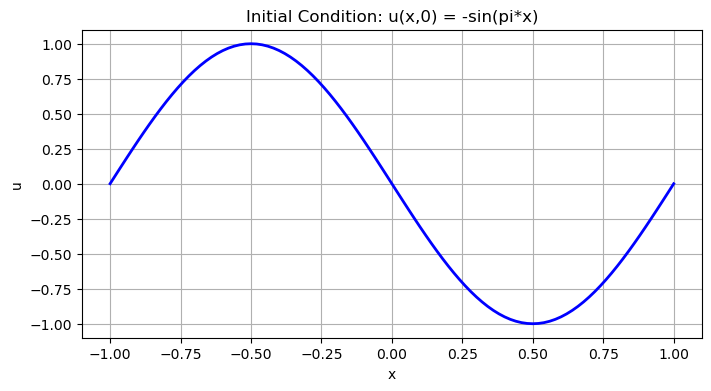

In [3]:
# Set the initial condition: u(x, 0) = -sin(pi * x)
u0 = -np.sin(np.pi * x)
u = u0.copy()  # make a copy for time stepping

# Plot the initial condition
plt.figure(figsize=(8, 4))
plt.plot(x, u, 'b-', lw=2)
plt.xlabel('x')
plt.ylabel('u')
plt.title("Initial Condition: u(x,0) = -sin(pi*x)")
plt.grid(True)
plt.show()


In [4]:
def step(u, dt, dx, nu):
    """
    Advance the solution u by one time step using a finite difference scheme.
    u: current solution (1D array)
    dt: time step
    dx: spatial step
    nu: viscosity coefficient
    Returns:
      u_new: updated solution after one time step
    """
    u_new = u.copy()
    # Use central differences for interior points
    for i in range(1, len(u)-1):
        # First derivative u_x
        u_x = (u[i+1] - u[i-1]) / (2 * dx)
        # Second derivative u_xx
        u_xx = (u[i+1] - 2*u[i] + u[i-1]) / (dx**2)
        # Time stepping update
        u_new[i] = u[i] + dt * (-u[i] * u_x + nu * u_xx)
    # Enforce Dirichlet boundary conditions: u(-1,t)=0 and u(1,t)=0
    u_new[0] = 0
    u_new[-1] = 0
    return u_new


Time integration complete. Number of snapshots: 51


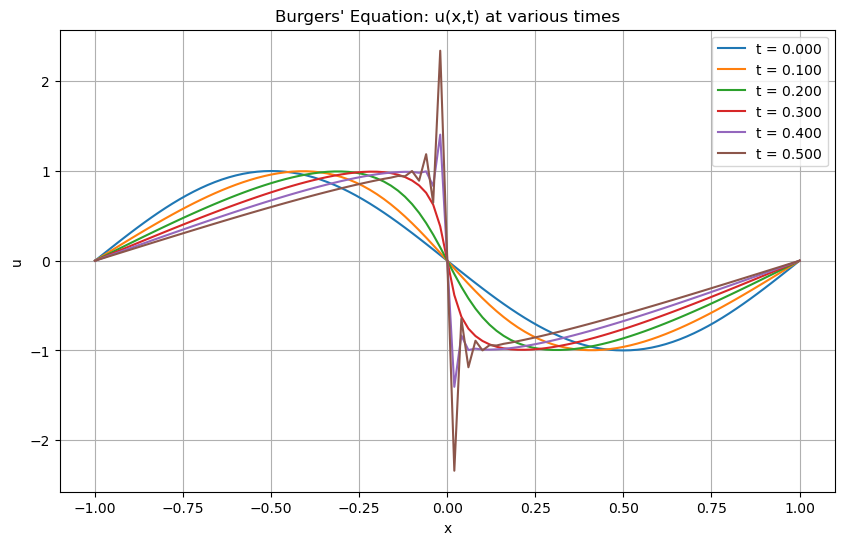

In [5]:
u = u0.copy()

# Time integration loop: evolve the solution and store snapshots for visualization
snapshots = []         # to store solution snapshots
snapshots.append(u.copy())

for n in range(nt):
    u = step(u, dt, dx, nu)
    # Save snapshot every 10 time steps
    if n % 10 == 0:
        snapshots.append(u.copy())

# Convert list of snapshots to a numpy array for easier handling
snapshots = np.array(snapshots)
print("Time integration complete. Number of snapshots:", snapshots.shape[0])

# Plot the solution at several time instants
plt.figure(figsize=(10, 6))
time_indices = np.linspace(0, snapshots.shape[0]-1, 6, dtype=int)
for idx in time_indices:
    plt.plot(x, snapshots[idx, :], label=f"t = {idx*10*dt:.3f}")
plt.xlabel('x')
plt.ylabel('u')
plt.title("Burgers' Equation: u(x,t) at various times")
plt.legend()
plt.grid(True)
plt.show()

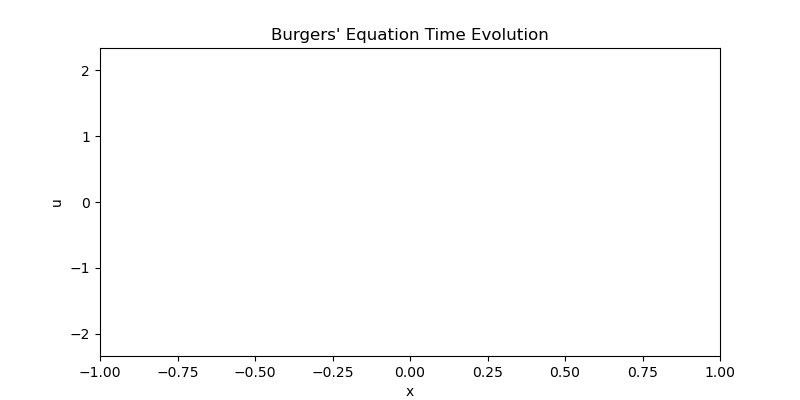

Animation saved as burgers_animation.gif


In [6]:
%matplotlib ipympl

# Create an animation of the solution evolution
fig, ax = plt.subplots(figsize=(8, 4))
line, = ax.plot([], [], 'b-', lw=2)
ax.set_xlim(-1, 1)
ax.set_ylim(np.min(snapshots), np.max(snapshots))
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.set_title("Burgers' Equation Time Evolution")

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, snapshots[i, :])
    ax.set_title(f"t = {i*10*dt:.3f}")
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=snapshots.shape[0],
                               interval=50, blit=True)

plt.show()

from matplotlib.animation import PillowWriter

# Create a PillowWriter instance with desired frames per second (fps)
writer = PillowWriter(fps=20)

# Save the animation as a GIF file
anim.save("burgers_animation.gif", writer=writer)
print("Animation saved as burgers_animation.gif")
